#Introduction

In March of last year the United States was faced with the realization that the Corona virus could not be contained and that a shut down of the american economy was ineviable. With uncertainty regarding of how contagious the virus was uncertainty spread, like the virus, casueing the stock market to fall drasticly. When the virus was deadly in other parts of the world between late January and early march the NASDAQ-100 fill by 7.4% and when the diseases reached America the market fell by antoher 12.4% the following two weeks. Not only was the value of the top 100 largest non-financial companies fall drastically the S&P 500 followed a similar trajectory.

This backstory is the foundation in which this research topic is built upon. How has COVID-19 effected the stock market? All be it a vague question this project telescopes into the effect that social media has had on the economy, specifically Twitter. With 22% of US adults active on twitter coupled with the fact that 12% of Americans get their news from Tiwtter this research question seemed plausable. How have tweets that mention COVID-19, or any words that relate to this topic" by news sources effects certain sectors of the Economy? 

#Methodology

Over the past seven months (May 21st to November 18th) Tweets have been collected from eleven different credible news sources on Titter (The New York Times, LA Times, Wall Street Journal, CNN, MSNBC, Boston Globe, BBC World, the New Yorker, Politico, CBB Breaking, an the Atlantic). I chose to focus on newsoutlets becasue of how the virus has become a polarizing topic in the U.S. Each day a dataframe is created, using a Twitter API, that contains the daily gathering of COVID-19 related tweets with the atributes of thier text, number of likes, and number of retweets. A sentiment analysis score wasran to identify which tweets were positive, negative, or neutral. I merged this data with the industyr level stock market data I collected. The top ten publically traded companies end of day stock market price fluctuations from the automobile, electronics,and solar industries were collected from Yahoo Finance and averaged out. These two datasets were then merged and used when creating models.   

# Automobile modeling

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
#Setting up the Dataframe


Tweets = pd.read_excel('/Users/calebdimenstein/Desktop/Twitter/Updated_Sources.xlsx',sheet_name = 0)
AutomobileStock = pd.read_csv('/Users/calebdimenstein/Desktop/Company Stocks/Automobiles Stock Changes.csv')

AutomobileStock['Date'] = pd.to_datetime(AutomobileStock['Date'],format = '%m/%d/%y').dt.strftime('%m/%d/%y')
Tweets['Date'] = pd.to_datetime(Tweets['Date'],format = '%Y-%m-%d').dt.strftime('%m/%d/%y')
Tweets['Count'] = 1
Tweets = Tweets.loc[Tweets['Date'] > '05/21/20']

Tweets_news = (Tweets.loc[(Tweets['screenName'] == 'nytimes') | (Tweets['screenName'] == 'latimes') | (Tweets['screenName'] == 'WSJ')
                          | (Tweets['screenName'] == 'CNN') |(Tweets['screenName'] == 'MSNBC') | (Tweets['screenName'] == 'BostonGlobe') |
                          (Tweets['screenName'] == 'BBCWorld') | (Tweets['screenName'] == 'NewYorker') | (Tweets['screenName'] == 'TheAtlantic')
                          | (Tweets['screenName'] == 'politico') | (Tweets['screenName'] == 'cnnbrk')])
Tweets_news = Tweets_news[~Tweets_news.tweets.str.contains("RT",regex = False)]
min_max_scaler = MinMaxScaler()
Tweets_news[['likes']] = min_max_scaler.fit_transform(Tweets_news[['likes']])



DateAgg = Tweets_news.set_index('Date').groupby(level=0).agg({'Count': np.sum,'compound':['mean'],'likes':['sum'],'retweets':['sum']})
dateAgg = DateAgg.columns=['_'.join(col) for col in DateAgg.columns.values]
DateCount = pd.DataFrame(DateAgg).reset_index()
#Merging the dataframes
DateAgg = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],AutomobileStock,how = 'right', on = 'Date')
DateAgg = DateAgg.dropna()
DateAgg = DateAgg.rename(columns={'Count_sum':'count','compound_mean':'mean'})


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Checking to see if the number of COVID-19 cases effect the number of Tweets

To check for an interaction effect between the main independent vairable in question, the number of COVID-19 related tweets. I checked to see if the number of new cases had an effect on the number of tweets relating to COVID-19 that were produced during that day. A linear regression was ran and outputed a R squared score of .48. The number of new cases, number of total cases, number of new deaths, and number of cumulative deaths only 48% of the variation in the number of COVID-19 related tweets put out the day after. This score is not segnificant enought prove that the number of tweets related to COVID-19 are effected by the number of new cases/deaths..

In [43]:
casesMerged = Tweets_news.set_index('Date').groupby(level=0).agg({'Count': np.sum,'compound':['mean']})
test = casesMerged.columns=['_'.join(col) for col in casesMerged.columns.values]
casesMergedFinal = pd.DataFrame(casesMerged).reset_index

casesMerged = pd.merge(casesMerged,CovidCases,how = 'right', on = 'Date')
casesMerged = casesMerged.dropna()
casesMerged = casesMerged.rename(columns={'Count_sum':'Num_tweets','compound_mean':'Sent_score'})



for index,row in casesMerged.iterrows():
    if index + 1 < casesMerged.shape[0]:
        casesMerged.loc[index,'Num_tweets'] = casesMerged.loc[index + 1,'Num_tweets']
y = casesMerged['Num_tweets']
print(casesMerged)
casesMerged = casesMerged.drop(columns = ['Num_tweets','Date',' Country',' Country_code', ' WHO_region', 'Sent_score'])
X = casesMerged

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)



#Linear Regression
linreg = LinearRegression().fit(X_train,y_train)
print('linear model coeff (w): {}'
     .format(linreg.coef_))
print('linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
print("")



         Date  Num_tweets  Sent_score  Country_code                   Country  \
0    05/22/20       108.0   -0.024511            US  United States of America   
1    05/23/20       100.0   -0.022954            US  United States of America   
2    05/24/20       134.0   -0.018950            US  United States of America   
3    05/25/20       139.0   -0.015716            US  United States of America   
4    05/26/20       170.0   -0.035561            US  United States of America   
..        ...         ...         ...           ...                       ...   
169  11/07/20        34.0   -0.009364            US  United States of America   
170  11/08/20       134.0    0.010971            US  United States of America   
171  11/09/20       130.0    0.052634            US  United States of America   
172  11/10/20        46.0    0.000554            US  United States of America   
173  11/11/20        46.0    0.029717            US  United States of America   

     WHO_region   New_cases

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Covid Cases compared to Number of Tweets

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


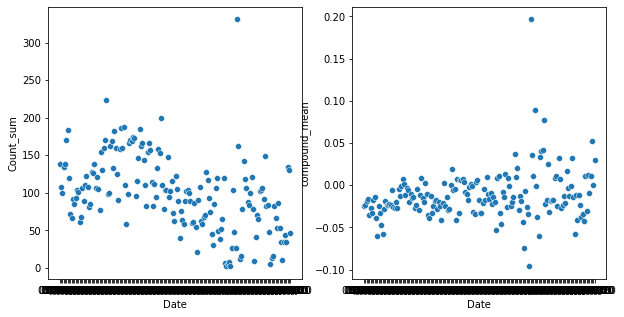

In [22]:
CovidCases = pd.read_excel('/Users/calebdimenstein/Desktop/Twitter/Cases.xlsx',sheet_name = 0)
CovidCases = CovidCases.rename(columns={'Date_reported':'Date'})
CovidCases['Date'] = pd.to_datetime(CovidCases['Date'],format = '%m/%d/%y').dt.strftime('%m/%d/%y')
CovidCases = CovidCases.loc[(CovidCases[' Country_code'] == 'US') & (CovidCases['Date'] > '05/21/20')]

casesMerged = Tweets_news.set_index('Date').groupby(level=0).agg({'Count': np.sum,'compound':['mean']})
test = casesMerged.columns=['_'.join(col) for col in casesMerged.columns.values]
casesMergedFinal = pd.DataFrame(casesMerged).reset_index

casesMerged = pd.merge(casesMerged,CovidCases,how = 'right', on = 'Date')
casesMerged = casesMerged.dropna()
fig, axes = plt.subplots(1,2, figsize = (10,5))
sns.scatterplot(ax = axes[0], data = casesMerged, x = 'Date', y = 'Count_sum')
sns.scatterplot(ax = axes[1], data = casesMerged, x = 'Date', y = 'compound_mean')

# 2X5 Stock compared to Number of Tweets

Before machine learning models were ran a visualization of how the number and sentiment scores of COVID-19 related tweets effect the end of day stock market price change in the three industries studied was conducted. From the first glance it is doubtful to say that there is a definiative corrolation between the number of tweets/sentimant score and the effect they have on end of day stock makret changes. All of the three industries, Automobile, electronic, and solar all exibit similar patterns for the number of COVID-19 related tweets and the change in stock market price... there is none. There is no unity between the points. Some companies responsed slightly positive as the number of tweets increase for a day but some companies expereince the exact opposite. The same results were found when performing the same visualization on sentimant analysis scores.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


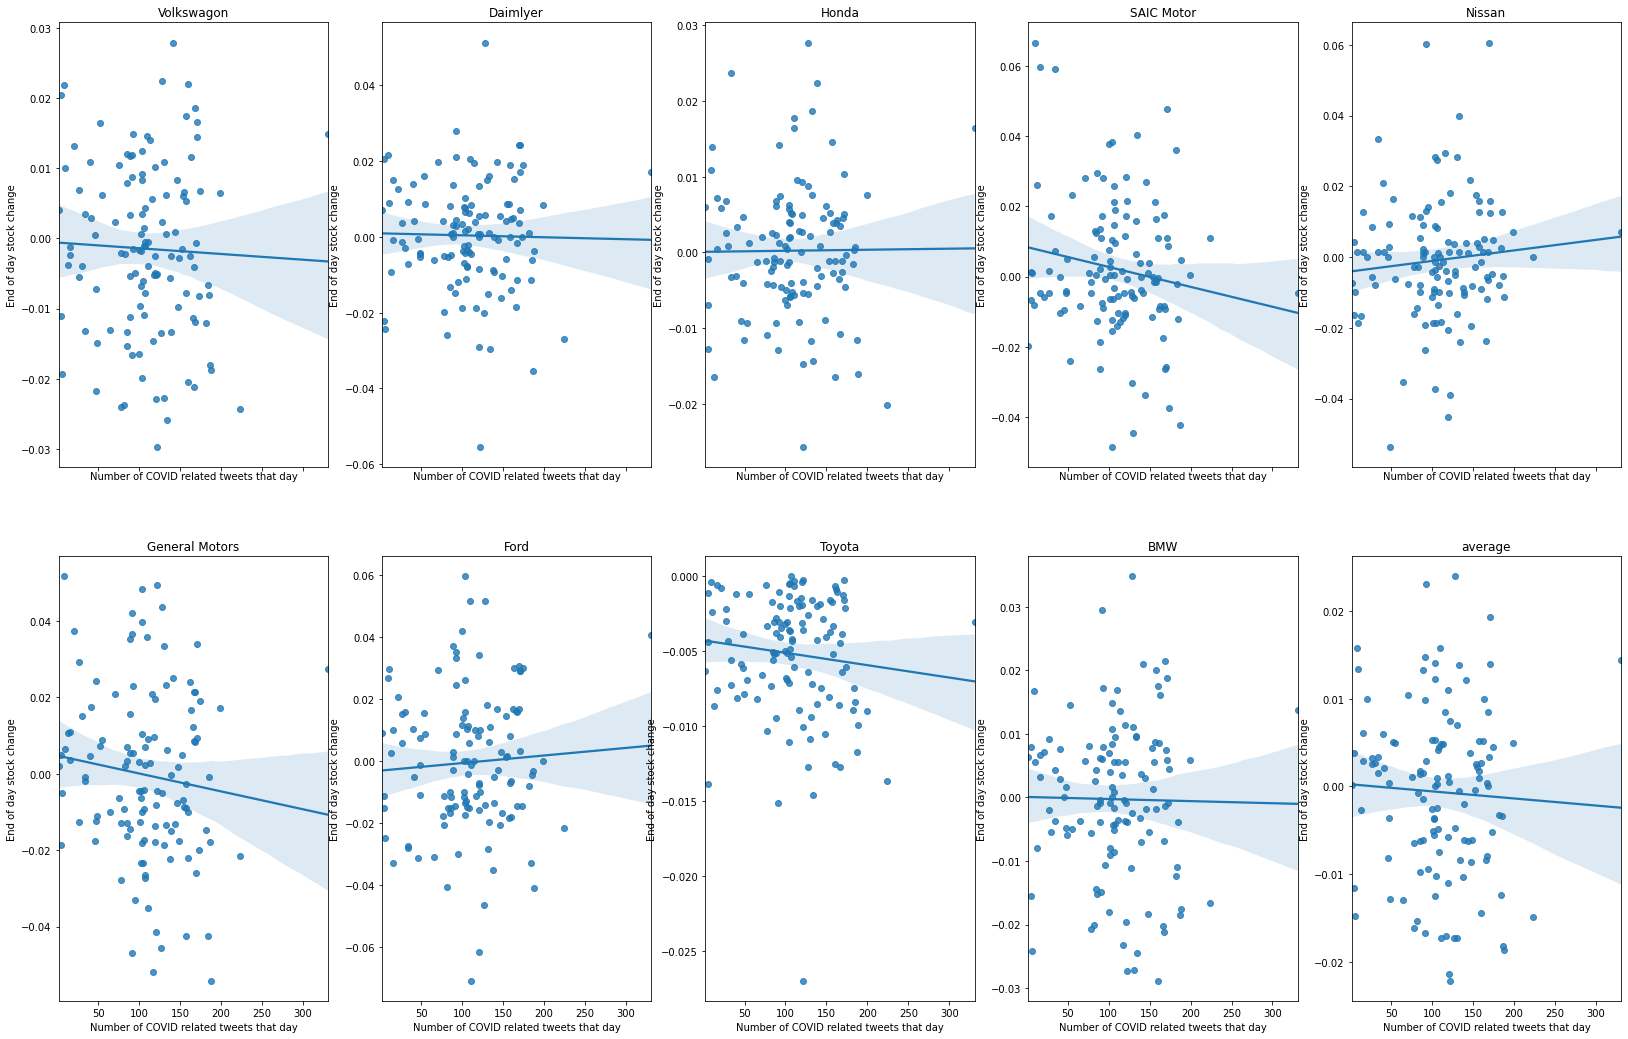

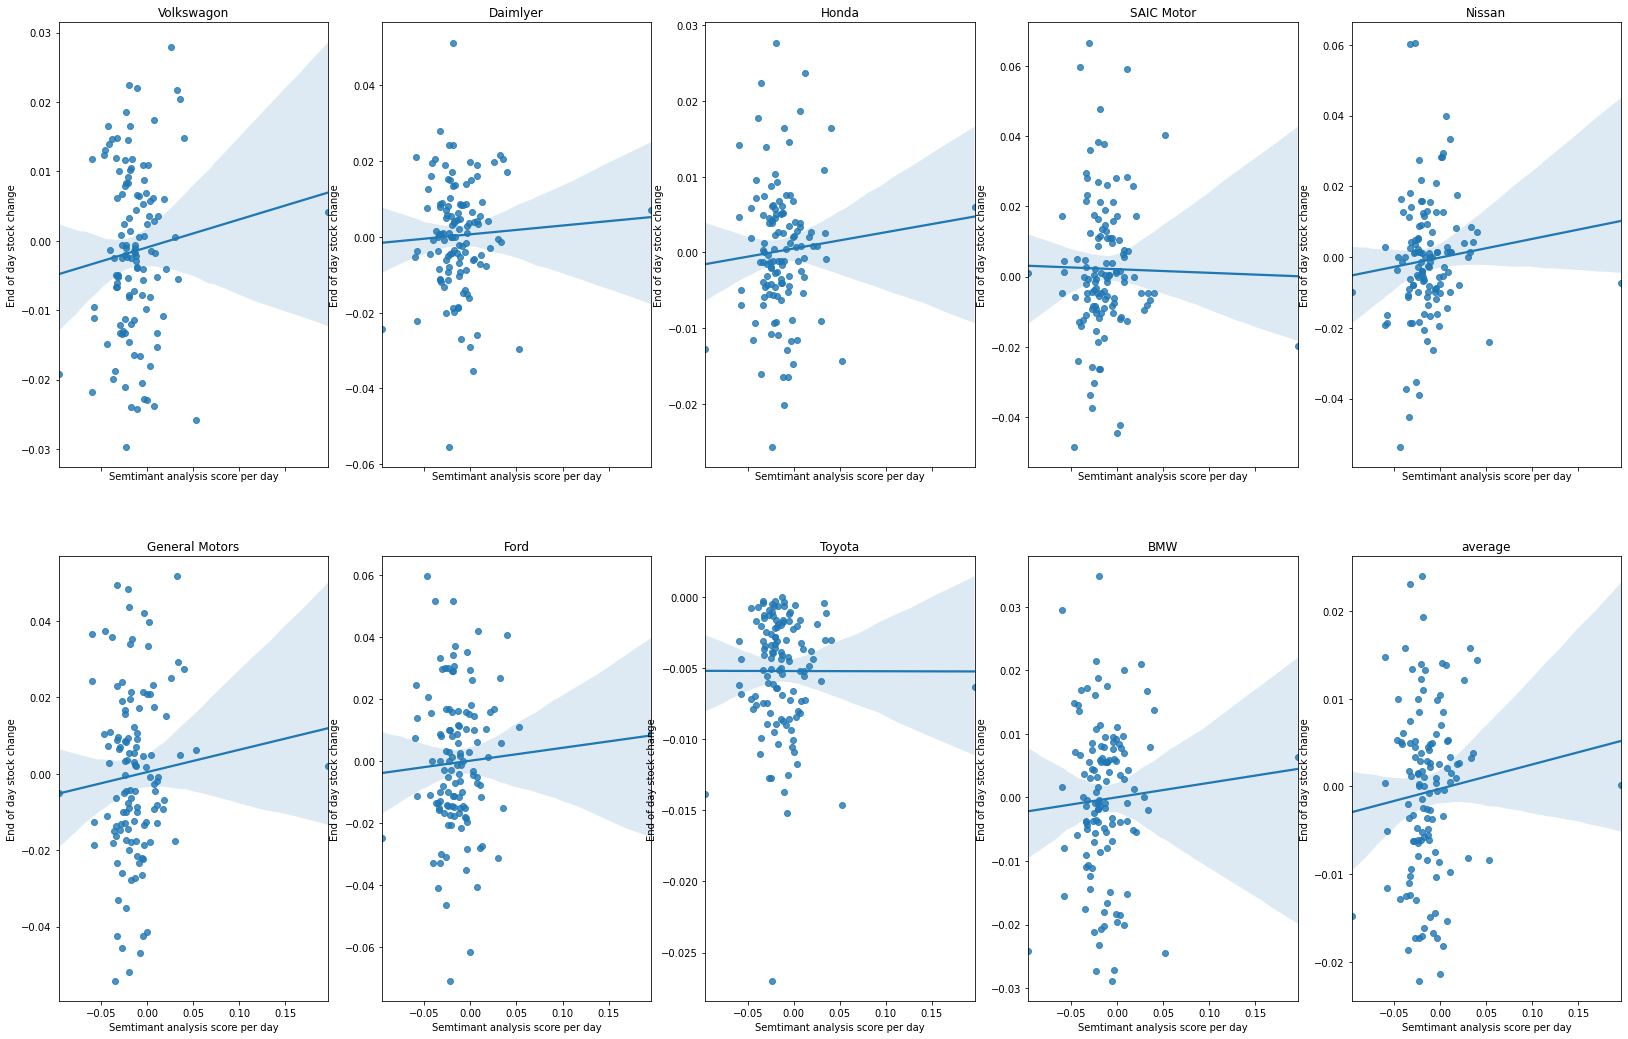

In [18]:
fig, axes = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
AutomobileArr = ['Volkswagon','General Motors','Daimlyer','Ford','Honda','Toyota','SAIC Motor', 'BMW', 'Nissan','average']
columns = [0,1,2,3,4]
rows = [0,1]
count = 0
for column in columns:
    for row in rows:
        sns.regplot(ax=axes[row, column], data = DateAgg, x = 'count', y = AutomobileArr[count])
        axes[row,column].set_title(AutomobileArr[count])
        axes[row,column].set(xlabel = "Number of COVID related tweets that day", ylabel = 'End of day stock change')
        count = count + 1
count = 0
print("")
print("")
figAutoSent, axesAutoSent = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
for column in column
    for row in rows:
        sns.regplot(ax=axesAutoSent[row, column], data = DateAgg, x = 'mean', y = AutomobileArr[count])
        axesAutoSent[row,column].set_title(AutomobileArr[count])
        axesAutoSent[row,column].set(xlabel = "Semtimant analysis score per day", ylabel = 'End of day stock change')
        count = count + 1

# 2X5 Stock compared to positivity/negativity of Tweets that day

# Electric company modeling

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


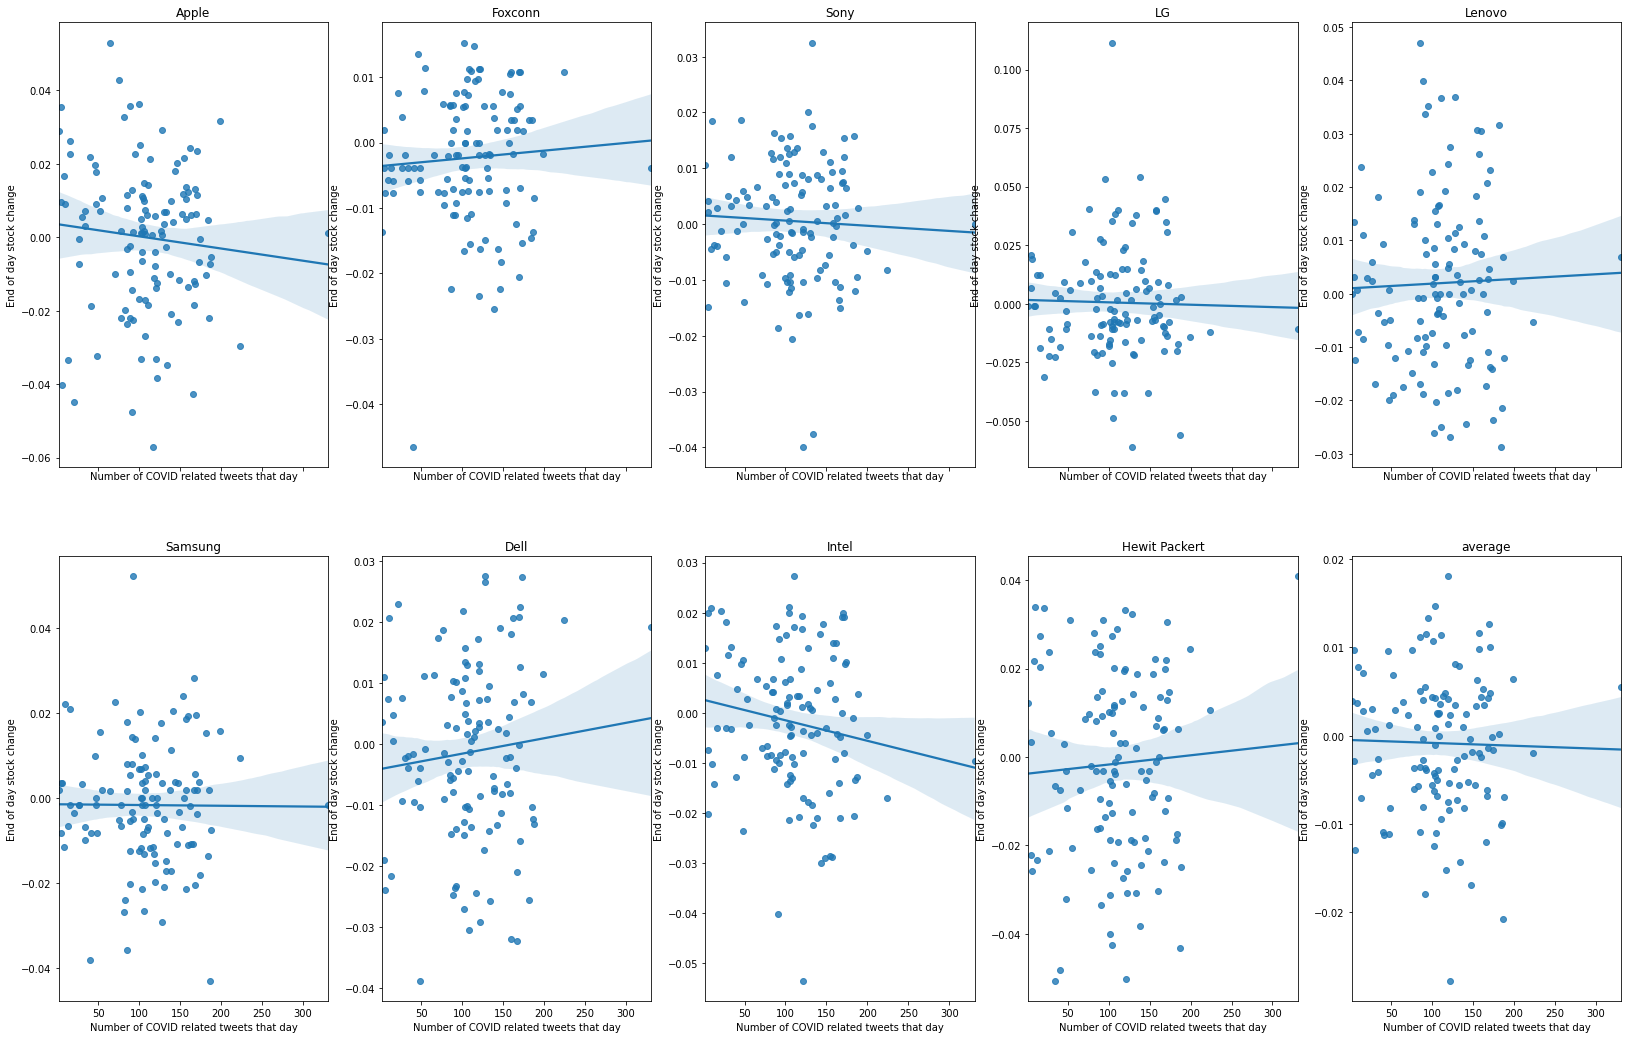

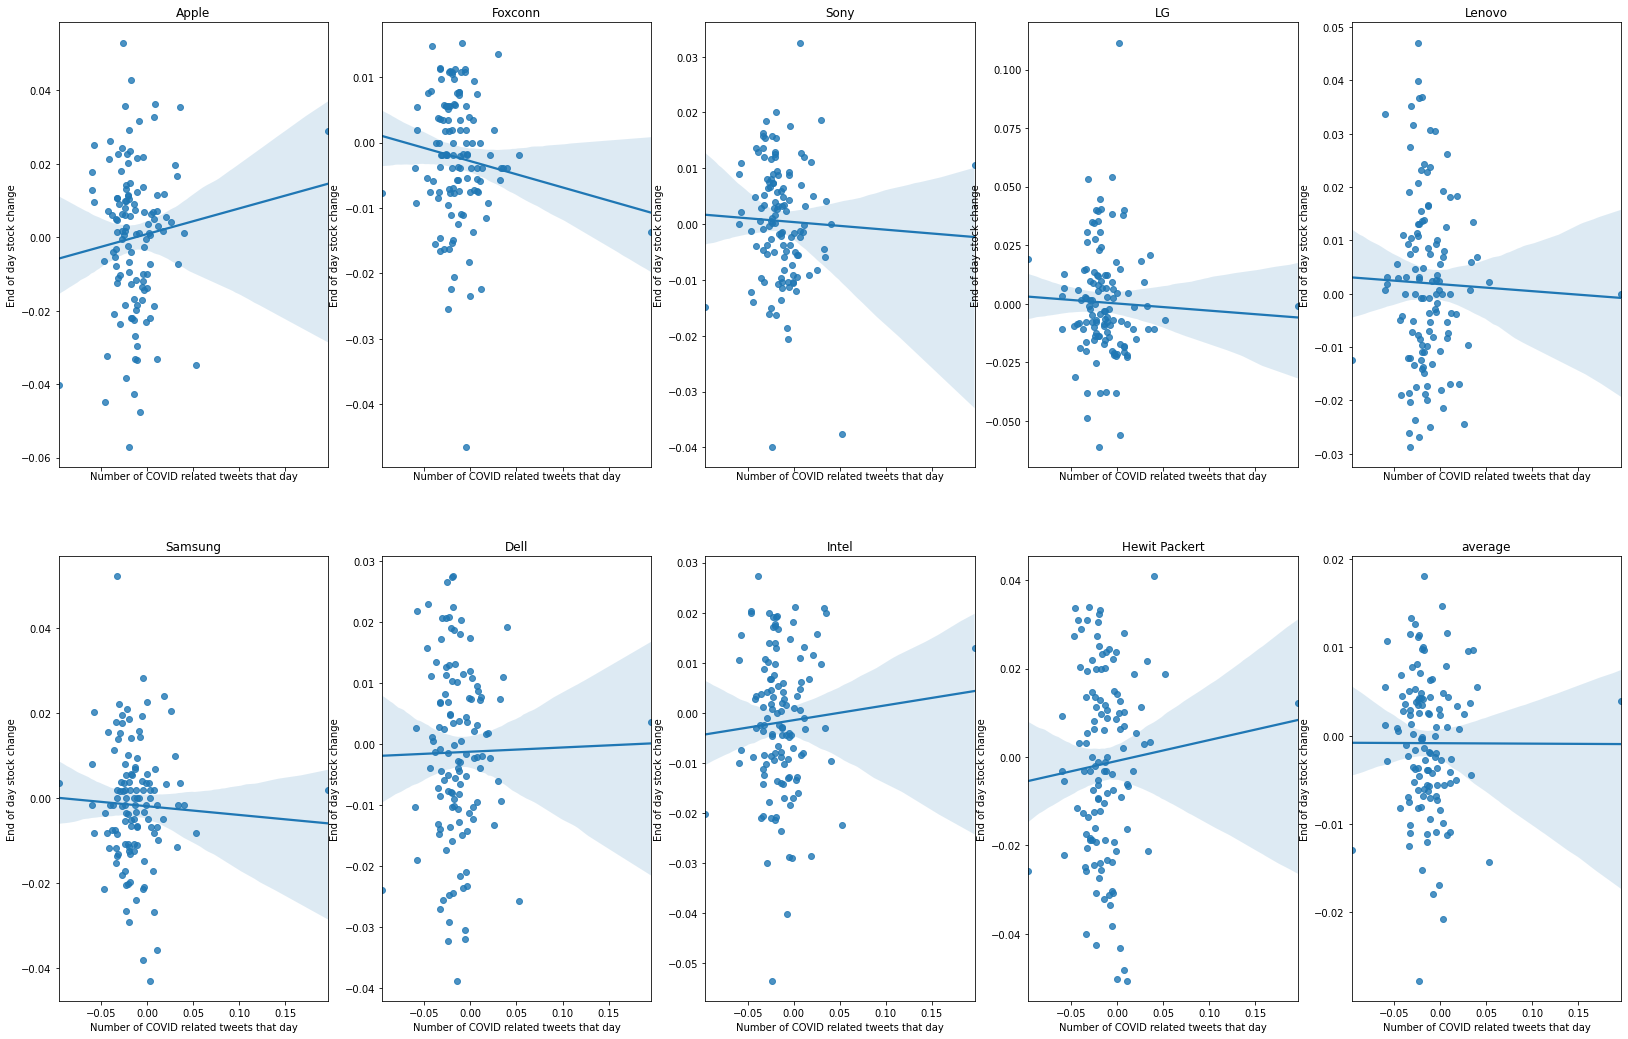

In [20]:
ElectronicStocks = pd.read_csv('/Users/calebdimenstein/Desktop/Company Stocks/Electronics Stock Changes.csv')
ElectronicStocks['Date'] = pd.to_datetime(ElectronicStocks['Date'],format = '%m/%d/%y').dt.strftime('%m/%d/%y')

ElectronicMerge = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],ElectronicStocks,how = 'right', on = 'Date')
ElectronicMerge = ElectronicMerge.dropna()
ElectronicMerge = ElectronicMerge.rename(columns={'Count_sum':'count','compound_mean':'mean','likes_sum':'likes','retweets_sum':'retweets'})

figElec, axesElec = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
ElectricArr = ['Apple','Samsung','Foxconn','Dell','Sony','Intel','LG', 'Hewit Packert', 'Lenovo','average']
columns = [0,1,2,3,4]
rows = [0,1]
count = 0
for column in columns:
    for row in rows:
        sns.regplot(ax=axesElec[row, column], data = ElectronicMerge, x = 'count', y = ElectricArr[count])
        axesElec[row,column].set_title(ElectricArr[count])
        axesElec[row,column].set(xlabel = "Number of COVID related tweets that day", ylabel = 'End of day stock change')
        count = count + 1

count = 0
figElecSent, axesElecSent = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
for column in columns:
    for row in rows:
        sns.regplot(ax=axesElecSent[row, column], data = ElectronicMerge, x = 'mean', y = ElectricArr[count])
        axesElecSent[row,column].set_title(ElectricArr[count])
        axesElecSent[row,column].set(xlabel = "Number of COVID related tweets that day", ylabel = 'End of day stock change')
        count = count + 1
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


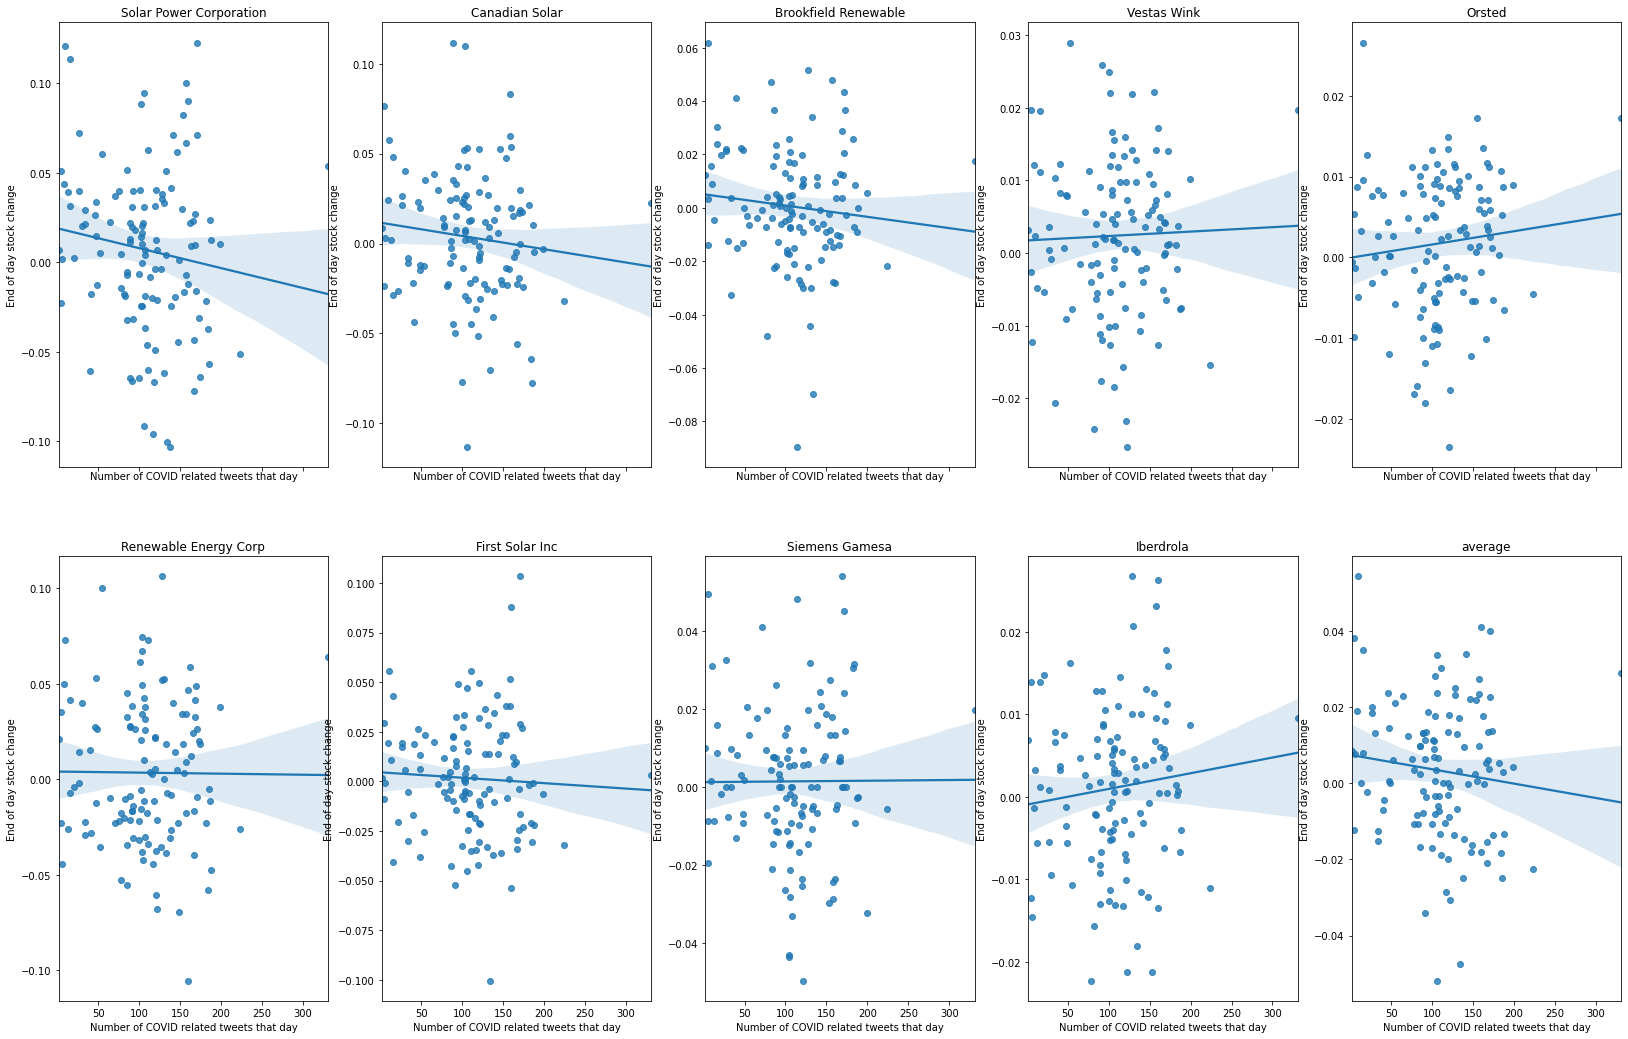

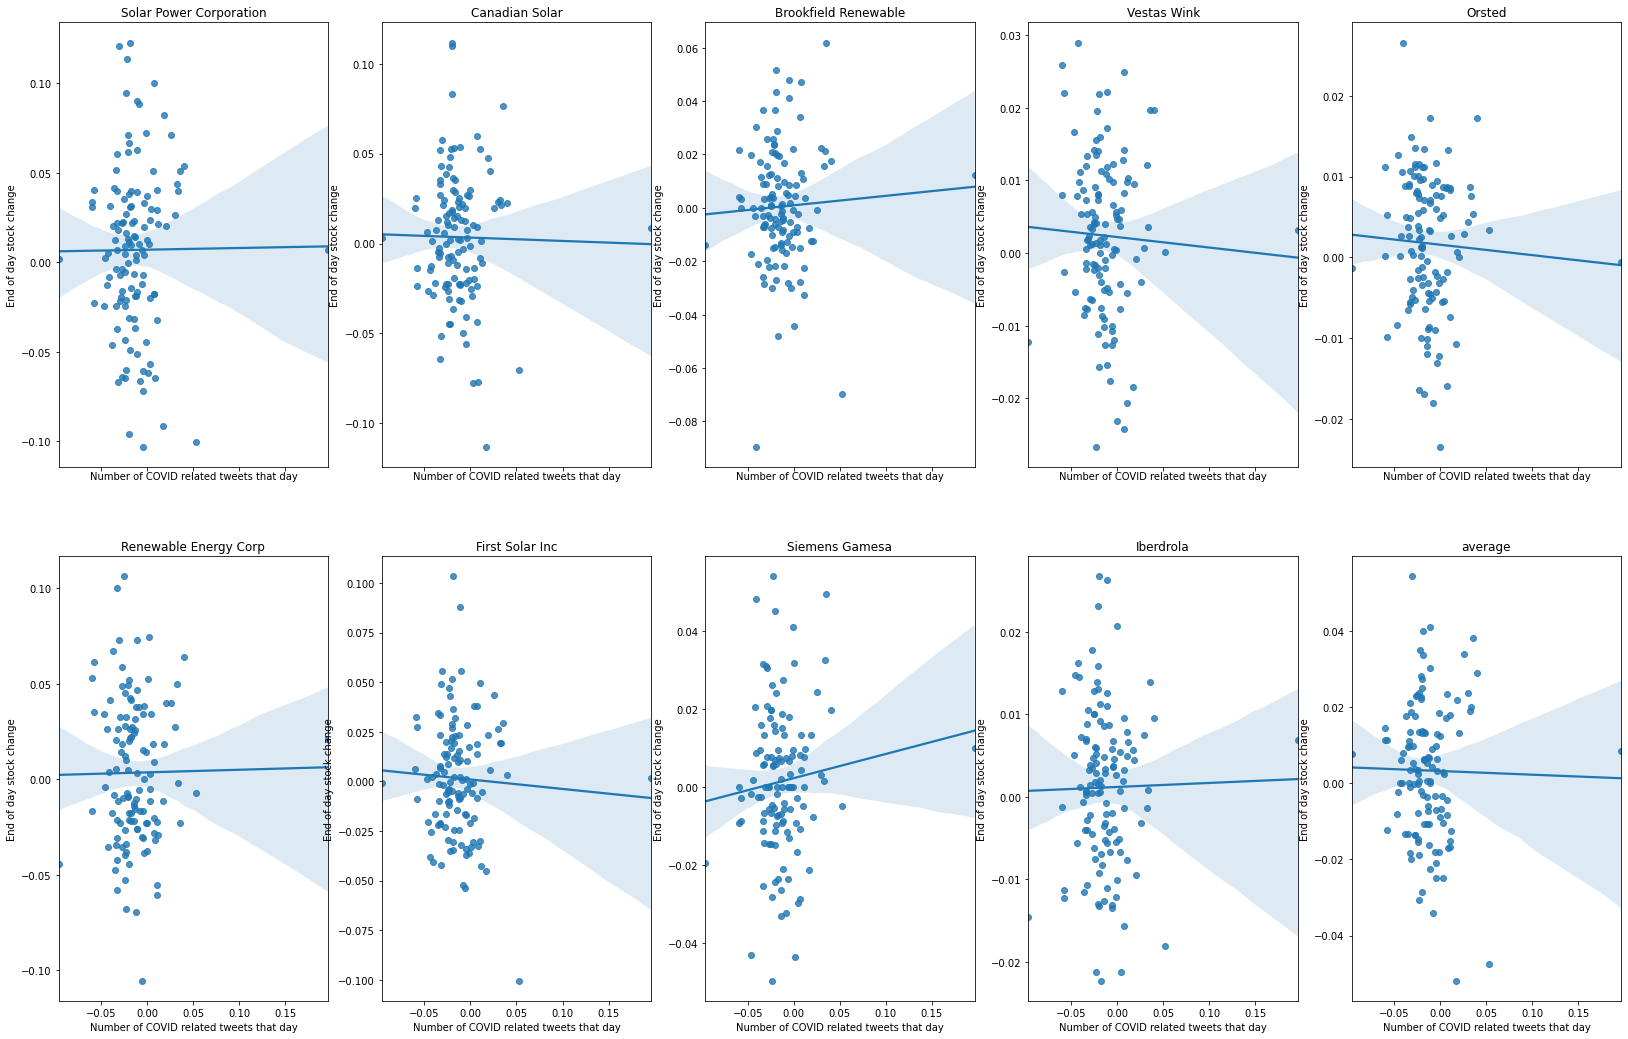

In [21]:
SolarStocks = pd.read_csv('/Users/calebdimenstein/Desktop/Company Stocks/Solar - All Companies.csv')
SolarStocks['Date'] = pd.to_datetime(SolarStocks['Date'],format = '%m/%d/%y').dt.strftime('%m/%d/%y')

SolarMerge = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],SolarStocks,how = 'right', on = 'Date')
SolarMerge = SolarMerge.dropna()
SolarMerge = SolarMerge.rename(columns={'Count_sum':'count','compound_mean':'mean','likes_sum':'likes','retweets_sum':'retweets'})

figSolarCount, axesSolarCount = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
SolarArr = ['Solar Power Corporation','Renewable Energy Corp','Canadian Solar','First Solar Inc','Brookfield Renewable','Siemens Gamesa','Vestas Wink', 'Iberdrola', 'Orsted','average']
columns = [0,1,2,3,4]
rows = [0,1]
count = 0
for column in columns:
    for row in rows:
        sns.regplot(ax=axesSolarCount[row, column], data = SolarMerge, x = 'count', y = SolarArr[count])
        axesSolarCount[row,column].set_title(SolarArr[count])
        axesSolarCount[row,column].set(xlabel = "Number of COVID related tweets that day", ylabel = 'End of day stock change')
        count = count + 1
count = 0
figSolarSent, axesSolarSent = plt.subplots(2,5, sharex=True, sharey=False, figsize=(28,18))
for column in columns:
    for row in rows:
        sns.regplot(ax=axesSolarSent[row, column], data = SolarMerge, x = 'mean', y = SolarArr[count])
        axesSolarSent[row,column].set_title(SolarArr[count])
        axesSolarSent[row,column].set(xlabel = "Number of COVID related tweets that day", ylabel = 'End of day stock change')
        count = count + 1
        

## Detecting outliers

Given the nature of the study outliers are expected to be seen. Over the past seven months dishartening stories about overcrowded hospitals have come to light in news publications. However, uplifting stories about vaccination approval and distribution have also circulated news sources. These stories effect the content of the tweets produced and as a result the daily average sentimant analysis score. Two whisker boxplots were created. One visualizing the variation of the number of tweets and the other visualiing the variation of average daily sentimant analysis scores.

The number of tweets whisker boxplot indicates that there is only one day that stands as an outlier. The median number of COVID-19 related tweets on a given day is 100 and the interquartile range spans from 66 tweets a day to 129 tweets a day. The Lower Whisker indicates that there was an error in data collection. The upper whisker however is not an error in data but infact a natural occurence. A Z-score was then ran on this data. There were two days where the number of tweets exceeded two standard deviations from the mean. The whisker and box plot for the variation in mean aggregate sentimant analysis scores. the Median sentimant analysis score for each day was -0.016 implying that on average daily tweets about COVID-19 are generally negative. The interquartile range spans from -0.026 to 0. A Z-score was also produeced and there were three days where the average sentimant analysis score was over two standard deviations from the mean.

It can be infered that as new stories come out about the COVID-19 virus the number of tweets produced do not vary but the sentimant behind them can vary drasticaly.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Whisker Box Plot Values for Number of Daily Tweets 
Upper Whisker is 224.0 
Upper Quartile is 129.5 
Median is 100.0 
Lower Quartile is 66.25
Lower Whister is 2.0

Whisker Box Plot Values for Dialy Average Sentimant Analysis Scores 
Upper Whisker is 0.03704 
Upper Quartile is -0.00012989146669321907 
Median is -0.016009894348482302 
Lower Quartile is -0.026497802197802196
Lower Whister is -0.05979166666666667


[-2.9326148523796527,
 -2.169327308900894,
 -1.6698524134670554,
 -1.6646325677362048,
 -1.6007114689309476,
 -1.5973430712850438,
 -1.4311859731227499,
 -1.219446002971135,
 -1.1943792712746342,
 -1.1124326988076219,
 -1.067932648825128,
 -1.0287646641402939,
 -1.0177967447897087,
 -1.0044793070526286,
 -0.9506579198270875,
 -0.936390335807294,
 -0.8884620357085865,
 -0.8809735966646662,
 -0.8286871912149851,
 -0.8141924468786973,
 -0.7716659971691977,
 -0.7661021593632857,
 -0.7605375300590015,
 -0.7549643921472182,
 -0.7484553074105561,
 -0.7471748317246544,
 -0.7408285010524451,
 -0.7334646880170288,
 -0.7305191628028619,
 -0.72484529395714,
 -0.7091455407656111,
 -0.6915407840289273,
 -0.6529887312728331,
 -0.614840249299718,
 -0.6086759034185321,
 -0.597540972404964,
 -0.5644936338694602,
 -0.5576799511287268,
 -0.5530331311787925,
 -0.5404709057073037,
 -0.5333992479220718,
 -0.5329858521771553,
 -0.5312816096084861,
 -0.5166079082189443,
 -0.5063841150501492,
 -0.49735908943352

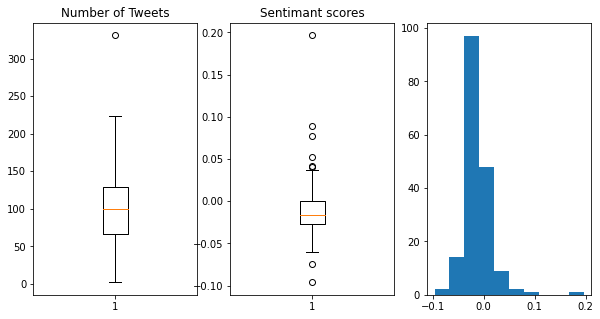

In [68]:
casesMerged = Tweets_news.set_index('Date').groupby(level=0).agg({'Count': np.sum,'compound':['mean']})
test = casesMerged.columns=['_'.join(col) for col in casesMerged.columns.values]
casesMergedFinal = pd.DataFrame(casesMerged).reset_index

casesMerged = pd.merge(casesMerged,CovidCases,how = 'right', on = 'Date')
casesMerged = casesMerged.dropna()
casesMerged = casesMerged.rename(columns={'Count_sum':'Num_tweets','compound_mean':'Sent_score'})

#print(casesMerged)
fig, ax = plt.subplots(1,3, figsize = (10,5))
box1 = ax[0].boxplot(casesMerged['Num_tweets'])
ax[0].set_title('Number of Tweets')
median = np.median(casesMerged['Num_tweets'])
upper_quartile = np.percentile(casesMerged['Num_tweets'], 75)
lower_quartile = np.percentile(casesMerged['Num_tweets'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = casesMerged['Num_tweets'][casesMerged['Num_tweets']<=upper_quartile+1.5*iqr].max()
lower_whisker = casesMerged['Num_tweets'][casesMerged['Num_tweets']>=lower_quartile-1.5*iqr].min()
print('Whisker Box Plot Values for Number of Daily Tweets \nUpper Whisker is {upperW} \nUpper Quartile is {upperQ} \nMedian is {median} \nLower Quartile is {lowerQ}\nLower Whister is {lowerW}'.format(upperW = upper_whisker, upperQ = upper_quartile, median = median, lowerQ = lower_quartile, lowerW = lower_whisker))
ax[1].boxplot(casesMerged['Sent_score'])
ax[1].set_title('Sentimant scores')
print('')

median = np.median(casesMerged['Sent_score'])
upper_quartile = np.percentile(casesMerged['Sent_score'], 75)
lower_quartile = np.percentile(casesMerged['Sent_score'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = casesMerged['Sent_score'][casesMerged['Sent_score']<=upper_quartile+1.5*iqr].max()
lower_whisker = casesMerged['Sent_score'][casesMerged['Sent_score']>=lower_quartile-1.5*iqr].min()
print('Whisker Box Plot Values for Dialy Average Sentimant Analysis Scores \nUpper Whisker is {upperW} \nUpper Quartile is {upperQ} \nMedian is {median} \nLower Quartile is {lowerQ}\nLower Whister is {lowerW}'.format(upperW = upper_whisker, upperQ = upper_quartile, median = median, lowerQ = lower_quartile, lowerW = lower_whisker))
ax[2].hist(casesMerged['Sent_score'])

sorted(stats.zscore(casesMerged['Sent_score']))
#sorted(stats.zscore(casesMerged['Num_tweets']))



When theres a lag the R-squared score is higher in the Test set but not so much the training set. May have to later check if I should run a logistic model.

# Modeling how the the stock changes depending on tweet data (News Sites)

This research topic was broken down into a binary classification problem. Can the aggregate number of daily tweets, number of likes, number of retweets, and sentimant analysis scores predict how the end of day price for the automobile, electronic, and solar industries will fluctuate. Since this is a binary problem the next question is whether a support vector machine model or a logistic regression model should be used. Since the independent variables are well identified and that there is a small number of training examples, a logistic model will be run. The most significant finding is in the Solar sector of the stock market. With an Roc Auc score of 0.72 this model does a decent job distinguisining between positive and negative classes. The models accuracy on the test set for solar companies is .80 which is .05 greater than the models accuracy for the training set. The Automobile industry saw a Roc Auc score of .52 which is only slightly better than the baseline prediction score of .5. The logistic model better better fit the training data than the test data, a training score of .56 and a test score of .52. Finaly the Roc Auc score for the electronics idustry was .50 which is a prediction level that is no better than the default. The accuracy score for the trainings set was .61 and the accuracy score for the test set was .29.

In [85]:
SolarStocks = pd.read_csv('/Users/calebdimenstein/Desktop/Company Stocks/Solar - All Companies.csv')

def g(row):
    if row['average'] < 0:
        val = 0
    else:
        val = 1
    return val

DateAgg = Tweets_news.set_index('Date').groupby(level=0).agg({'Count': np.sum,'compound':['mean'],'likes':['sum'],'retweets':['sum']})
DateAgg = DateAgg.reset_index()

#Merging the dataframes
DateAggAuto = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],AutomobileStock,how = 'right', on = 'Date')
DateAggAuto = DateAggAuto.dropna()
DateAggAuto = DateAggAuto.rename(columns={'Count_sum':'count','compound_mean':'mean_sent'})

DateAggElec = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],ElectronicStocks,how = 'right', on = 'Date')
DateAggElec = DateAggElec.dropna()
DateAggElec = DateAggElec.rename(columns={'Count_sum':'count','compound_mean':'mean_sent'})

DateAggSolar = pd.merge(DateCount[['Date','Count_sum','compound_mean','likes_sum','retweets_sum']],SolarStocks,how = 'right', on = 'Date')
DateAggSolar = DateAggSolar.dropna()
DateAggSolar = DateAggSolar.rename(columns={'Count_sum':'count','compound_mean':'mean_sent'})

#fig = plt.figure()
#plt.boxplot(DateAgg[;])
dfArr = [DateAggAuto, DateAggElec, DateAggSolar]
dfType = ['Automobile','Electric','Solar']
for df,industry in zip(dfArr,dfType):
    if industry == 'Solar':
        for index,row in df.iterrows():
            if index + 1 < 241:
                df.loc[index,'average'] = df.loc[index + 1, 'average']
    else:
        for index,row in df.iterrows():
            if index + 1 <= 248:
                df.loc[index,'average'] = df.loc[index + 1, 'average']

    df['pos_neg'] = df.apply(g,axis = 1)
    print(industry, ' Linear models')
    y = df.iloc[:,-1]
    X = df[['count','mean_sent','likes_sum', 'retweets_sum']]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0)
    clf = LogisticRegression(solver = 'liblinear', C = 100).fit(X_train,y_train)
    print('Accuracy of Logistic regression classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))
    print('Accuracy of Logistic regression classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))
    roc_auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])
    print('Roc Auc score is ', roc_auc)
    
   
    print("")
    print("")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Automobile  Linear models
Accuracy of Logistic regression classifier on training set: 0.56
Accuracy of Logistic regression classifier on test set: 0.52
Roc Auc score is  0.5231404958677686


Electric  Linear models
Accuracy of Logistic regression classifier on training set: 0.61
Accuracy of Logistic regression classifier on test set: 0.29
Roc Auc score is  0.5062841530054645


Solar  Linear models
Accuracy of Logistic regression classifier on training set: 0.75
Accuracy of Logistic regression classifier on test set: 0.80
Roc Auc score is  0.7222222222222222




##Modeling how the the stock changes depending on tweet data (With Obama and Biden)

In [90]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
import nltk
import re
import gensim.corpora as corpora
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint
nltk.download('stopwords')

stop_words = stopwords.words('english')
removeword = ['https','tco','coronavirus','Covid','pandemic','COVID','virus']
Tweets_news['tweets_cleaned'] = \
Tweets_news['tweets'].map(lambda x: re.sub('[,\.!?]','',x))
pat = r'\b(?:{})\b'.format('|'.join(removeword))

Tweets_news['tweets_cleaned'] = Tweets_news['tweets_cleaned'].str.replace(pat,"")

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(Tweets_news['tweets_cleaned']))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=80) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
data_words_nostops = remove_stopwords(data_words)


data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


mallet_path = '/Users/calebdimenstein/Desktop/mallet/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=35, id2word=id2word)

pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
print(vis)
'''
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
'''

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:14: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \.
<ipython-input-91-9e013d9b51a6>:14: DeprecationWarning: invalid escape sequence \.
  Tweets_news['tweets'].map(lambda x: re.sub('[,\.!?]','',x))
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/calebdimenstein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(16,
  [('patient', 0.09787867510234462),
   ('hospital', 0.07033866765909937),
   ('drug', 0.03423892817268329),
   ('treat', 0.03386676590993673),
   ('send', 0.02679568291775214),
   ('hospitalize', 0.02530703386676591),
   ('care', 0.020468924451060664),
   ('recover', 0.020468924451060664),
   ('emergency', 0.01935243766282099),
   ('reduce', 0.014514328247115743)]),
 (5,
  [('outbreak', 0.0894603404563564),
   ('city', 0.054690329590728),
   ('bad', 0.054690329590728),
   ('early', 0.05143064107207534),
   ('large', 0.05106845345889171),
   ('restriction', 0.05070626584570807),
   ('place', 0.03332126041289388),
   ('event', 0.030785947120608476),
   ('wave', 0.026077508149221298),
   ('pay', 0.02064469395146686)]),
 (17,
  [('testing', 0.09149338374291115),
   ('expert', 0.07107750472589792),
   ('change', 0.06162570888468809),
   ('lockdown', 0.05822306238185255),
   ('question', 0.050283553875236295),
   ('strategy', 0.024196597353497166),
   ('avoid', 0.023062381852551984),


'\ndef compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):\n    coherence_values = []\n    model_list = []\n    for num_topics in range(start, limit, step):\n        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)\n        model_list.append(model)\n        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=\'c_v\')\n        coherence_values.append(coherencemodel.get_coherence())\n\n    return model_list, coherence_values\nmodel_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)\nlimit=40; start=2; step=6;\nx = range(start, limit, step)\nplt.plot(x, coherence_values)\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence_values"), loc=\'best\')\nplt.show()\n'

In [ ]:
doc_lens = [len(d) for d in Tweets_news.tweets_cleaned]

# Plot
plt.figure(figsize=(40,27), dpi=1600)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 125), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=100)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=50))
plt.show()